In [ ]:
! pip install pennylane
! pip install qutip
! pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 18.5 MB/s eta 0:00:00


In [3]:
from drive.MyDrive.Notebook_tesis_def.dll.gate_procesor import *
from drive.MyDrive.Notebook_tesis_def.dll.hello import *
from drive.MyDrive.Notebook_tesis_def.dll.spin_procesor import *
from drive.MyDrive.Notebook_tesis_def.dll.main_fun import *
from drive.MyDrive.Notebook_tesis_def.dll.baseline_dru import *
from drive.MyDrive.Notebook_tesis_def.dll.cost_fub import *
from drive.MyDrive.Notebook_tesis_def.dll.models import *

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Circuito en Alto Nivel - Clase baseline

# Seccion I

### 1 qubit

In [ ]:
import pandas as pd
# data set:
X, y =  make_IRIS_v2(3,3)
alpha_R = 0.5

In [ ]:
model = Modelo_DRU(qcircuit_1_qubit_mixed, Trace_Distance_v3,
                        epochs = 2, n_clases = 3, n_qubits = 1,
                        features = 3, num_layers = 10, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False)
paramters_1q, bias_1q = model.fit(X, y)

Epoch: 100%|██████████| 2/2 [00:18<00:00,  9.03s/it]


In [ ]:
X_test = model.X_val
y_test = model.y_val

In [ ]:
from itertools import product
import random

# Tus listas
f_cost_list = [Trace_Distance_v3, fidelity_cost, Von_Neumman_Divergence_v2, Renyi_Divergence_v2]
Noise_range = [0.0, 0.3, 0.5, 0.9]
N_layers = [3, 4, 5, 6, 10]
B0 = [1e-3, 10e-3, 1]
tf_noise = [True]
noise_std = [0.0, 1e-3, 1e-1]
T1s = [1e-3]
T2s = [23e-6, 6e-6]

# Generar todas las combinaciones posibles
all_combinations = list(product(f_cost_list, Noise_range, N_layers,
                                B0, tf_noise, noise_std, T1s,T2s))

# Barajar aleatoriamente las combinaciones
random.shuffle(all_combinations)

# Conjunto para realizar un seguimiento de las combinaciones utilizadas
used_combinations = set()

N = 100

# Realizar las pruebas
for i in range(N):

  combination = all_combinations[i]

  f_cost_i, q_noise,  n_layers, B0, tf_noise, noise_std, t1, t2 = combination

  if t1 == 0 or t2 == 0:
    tf_n = False
  else:
    tf_n = True

  if combination not in used_combinations:

    model = Modelo_DRU(qcircuit_1_qubit_mixed, f_cost_i,
                          epochs = 10, n_clases = 3, n_qubits = 1,
                          features = 3, num_layers = n_layers, alpha_noise = q_noise,
                          save_process = False)

    paramters_1q, bias_1q = model.fit(X, y)
    #X_test = model.X_val
    #y_test = model.y_val
    y_pred = []

    for x in X_test:
      dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=50,
                                        N_qubits = 1, tf_noise = tf_noise, noise_std = noise_std,
                                        tf_quantum_noise = tf_n,
                                        T1=t1, T2=t2)
      state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_1q, x, bias=bias_1q)
      dm_out = density_matrix_1(state_dru.full())
      clas_pred = _test_pulse_model(dm_out, model.state_labels)
      y_pred.append(clas_pred)

    report_dict = classification_report(y_test, y_pred, output_dict = True)
    write = report_to_excel(report_dict, "Save_excel_1q_iris_3_3.xlsx")
    write.dict_to_excel(1, tf_noise, noise_std, dru_circuit.B0, dru_circuit.B1,
                        n_layers, False,
                        f_cost_i, dru_circuit.T1, dru_circuit.T2, q_noise)

    # Agregar la combinación al conjunto de utilizadas
    used_combinations.add(combination)


# Seccion II


## Pulsos

Grafica de pulsos del procesador:

In [ ]:
def plot_pulses_v2(self, verbose = 1, key_show = 'all'):
  resultado = self.pulse_type
  glob_time = self.global_time
  for key in resultado:
    list_pulses = resultado[key]
    if list_pulses[0]['Type_pulse'] == 'Unitary':
      global_time_sim = np.linspace(0, dru_circuit.global_time , 1000)
      B1_pulses = np.zeros(len(global_time_sim ))
      B0_pulses = np.zeros(len(global_time_sim ))
      for dict_pulse in list_pulses:
        # B0 results
        args2= {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f']}
        B0_i = dict_pulse['B0'] * pulse_z(
                                  global_time_sim,
                                  args2)
        B0_pulses += np.array(B0_i)
        # B1 results
        # Correccion:
        if dict_pulse['B1'] != 0:
          dv = self.noise_std/abs(dict_pulse['B1'])
        else:
          dv = 0
        args2= {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f'], "std_noise": dv }
        B1_i = dict_pulse['B1'] * pulse_x_with_noise(
                                  global_time_sim,
                                  args2)
        B1_pulses += np.array(B1_i)
      # Plot
      plt.figure(figsize=(8,3))
      plt.plot(global_time_sim, B0_pulses)
      plt.title("Pulse sequence for B0")
      plt.xlabel("time [s]")
      plt.ylabel("B0 [T]")
      plt.grid()
      plt.show()

      plt.figure(figsize=(8,3))
      plt.plot(global_time_sim, B1_pulses)
      plt.title("Pulse sequence for B1")
      plt.xlabel("time [s]")
      plt.ylabel("B1 [T]")
      plt.grid()
      plt.show()

    elif list_pulses[0]['Type_pulse'] == "Two_Qubits":
      global_time_sim = np.linspace(0, dru_circuit.global_time , 1000)
      J_pulses = np.zeros(len(global_time_sim ))
      for dict_pulse in list_pulses:
        args2= {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f']}
        J_i = dict_pulse['J'] * pulse_x(
                                  global_time_sim,
                                  args2)
        J_pulses += np.array(J_i)
      plt.figure(figsize=(8,3))
      plt.plot(global_time_sim, J_pulses)
      plt.title("Pulse sequence for J")
      plt.xlabel("time [s]")
      plt.ylabel("J [hz]")
      plt.grid()
      plt.show()

### Pulsos 1 qubit

In [ ]:
X, y =  make_IRIS_v2(3,3)

model = Modelo_DRU(qcircuit_1_qubit_mixed, Trace_Distance,
                        epochs = 2, n_clases = 3, n_qubits = 1,
                        features = 3, num_layers = 10, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False)
paramters_1q, bias_1q = model.fit(X, y)

Epoch: 100%|██████████| 2/2 [00:17<00:00,  8.59s/it]


In [ ]:
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000,
                                     N_qubits = 1,
                                     tf_noise = False,
                                     noise_std = 0.0000)

state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q)
state_dru

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.23959532+0.88453303j]
 [0.24060704+0.31984943j]]

#### Nuevas graficas

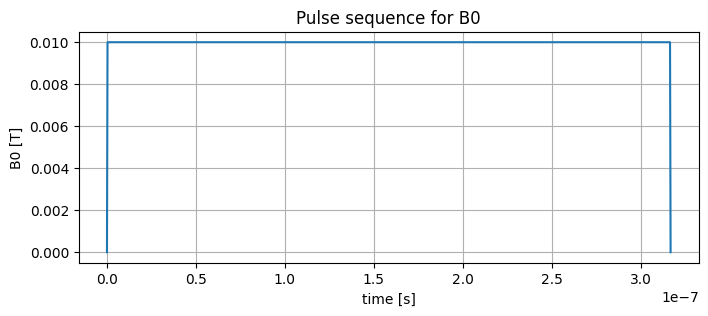

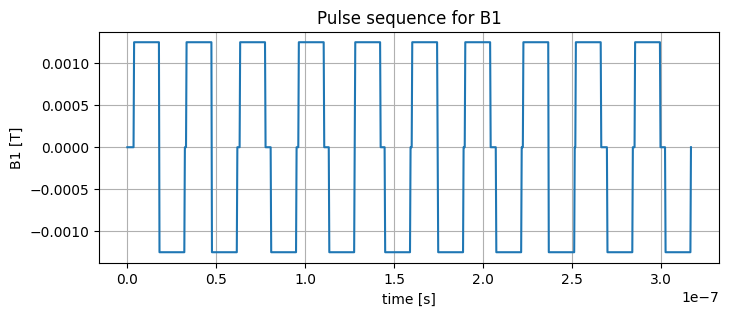

In [ ]:
plot_pulses_v2(dru_circuit)

### Pulsos 2 qubits - sin entrelazamiento

Aca se utilizo la version 3 de la distancia de traza compatible con n >= 2 qubits.

In [ ]:
X, y =  make_IRIS_v2(3,3)

model = Modelo_DRU(qcircuit_2_qubit_mixed, Trace_Distance_v3,
                        epochs = 2, n_clases = 3, n_qubits = 2,
                        features = 3, num_layers = 10, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False)

paramters_2q_wo_en, bias_2q_wo_en = model.fit(X, y)

Epoch: 100%|██████████| 2/2 [00:33<00:00, 16.84s/it]


In [ ]:
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,
                                     N_qubits = 2,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0)),
                                     )

state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_2q_wo_en,
                                             model.X_val[1],
                                             bias_2q_wo_en,
                                            )
state_dru

N_layers = 10
params_shape = (20, 3)
params_shape = (20, 3)


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.70665454+0.07502383j]
 [-0.0595478 -0.6281615j ]
 [-0.12901642+0.19371372j]
 [-0.17070151-0.11648493j]]

#### Nuevas graficas

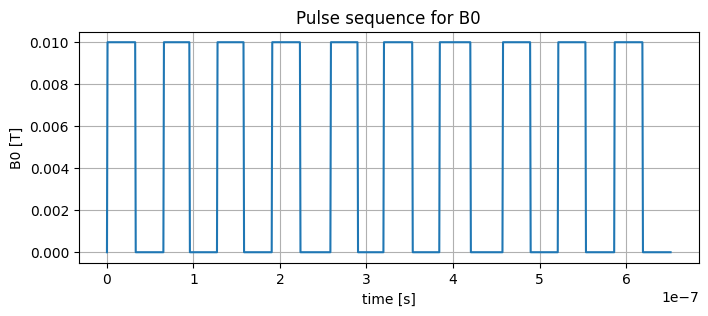

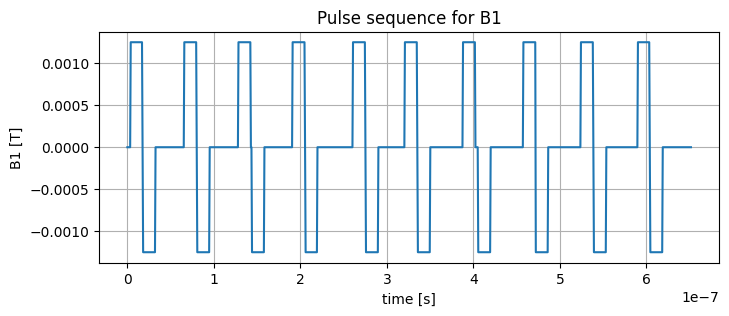

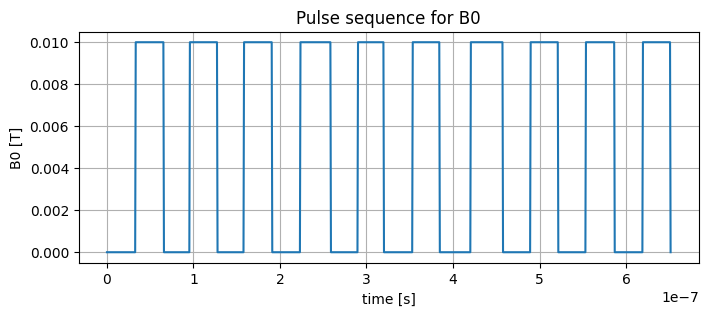

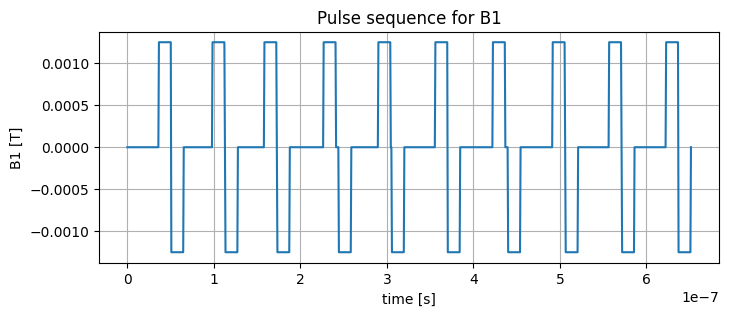

In [ ]:
# Nueva forma
plot_pulses_v2(dru_circuit)

### Pulsos 2 qubits - con entrelazamiento

In [ ]:
X, y =  make_IRIS_v2(3,3)

model = Modelo_DRU(qcircuit_2_qubit_mixed, Trace_Distance_v3,
                        epochs = 2, n_clases = 3, n_qubits = 2,
                        features = 3, num_layers = 10, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False)

paramters_2q_with_en, bias_2q_with_en = model.fit(X, y)

Epoch: 100%|██████████| 2/2 [00:34<00:00, 17.04s/it]


In [ ]:
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,
                                     N_qubits = 2,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0)),
                                     J = 12e6)

state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_2q_with_en,
                                             model.X_val[1],
                                             bias = bias_2q_with_en,
                                             entanglement = True)
state_dru

N_layers = 10
params_shape = (20, 3)
params_shape = (20, 3)
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.29710135-0.521387j  ]
 [ 0.22003256+0.16210869j]
 [-0.27546696-0.62036699j]
 [-0.07953037-0.31325789j]]

#### Nueva version

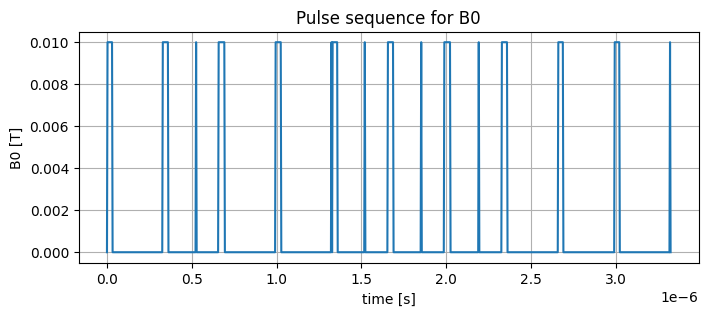

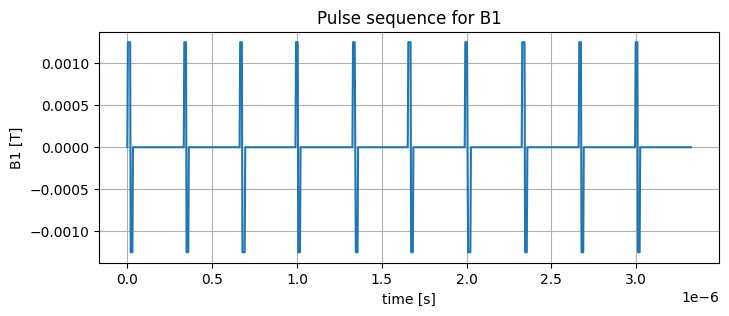

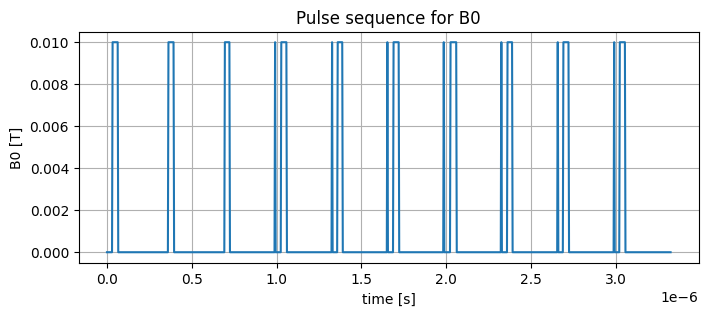

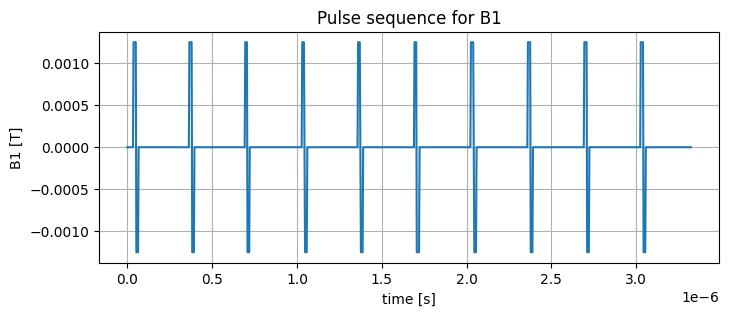

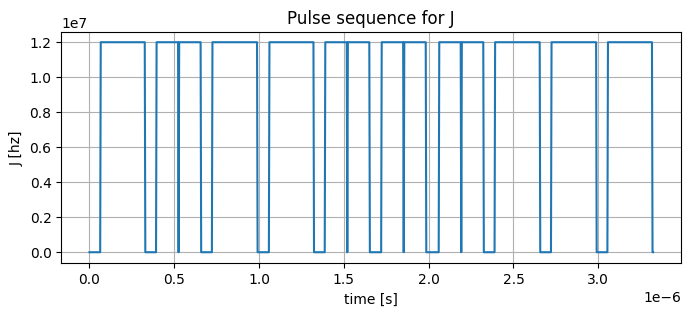

In [ ]:
plot_pulses_v2(dru_circuit)

### Pulsos 4 qubits - sin entrelazamiento

In [ ]:
X, y =  make_IRIS_v2(3,3)

model = Modelo_DRU(qcircuit_4_qubit_mixed, Trace_Distance_v3,
                        epochs = 2, n_clases = 3, n_qubits = 4,
                        features = 3, num_layers = 5, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False)

paramters_4q, bias_4q = model.fit(X, y)

Epoch: 100%|██████████| 2/2 [00:35<00:00, 17.82s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,
                                     N_qubits = 4,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0)))

state_dru = dru_circuit.qcircuit_DRU_4_Qubit(paramters_4q,
                                             model.X_val[1],
                                             bias=bias_4q,
                                             entanglement = False)
state_dru

Contador general 0
Contador general 1
Contador general 2
Contador general 3
Contador general 4


Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[-0.04089993-0.16460666j]
 [ 0.49641791+0.38377129j]
 [-0.11879396+0.09534337j]
 [ 0.12590207-0.54926157j]
 [-0.08148931+0.01628127j]
 [ 0.19909003-0.2342449j ]
 [ 0.04396647+0.06030347j]
 [-0.26595983-0.0740841j ]
 [ 0.02209017+0.0337707j ]
 [-0.14159505-0.04729758j]
 [ 0.01921201-0.03072915j]
 [ 0.01477129+0.13325277j]
 [ 0.01702925-0.01004484j]
 [-0.02636172+0.0682254j ]
 [-0.0146033 -0.01010006j]
 [ 0.06555123-0.00420509j]]

#### Version actual

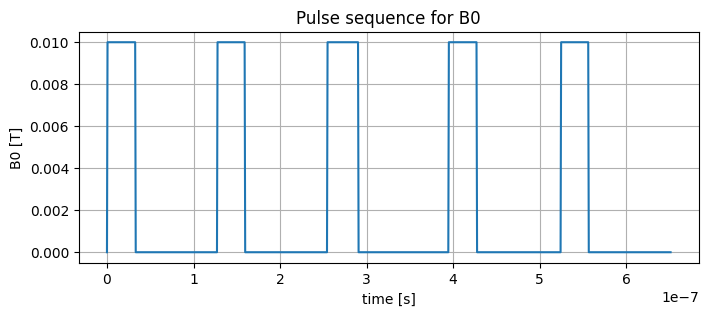

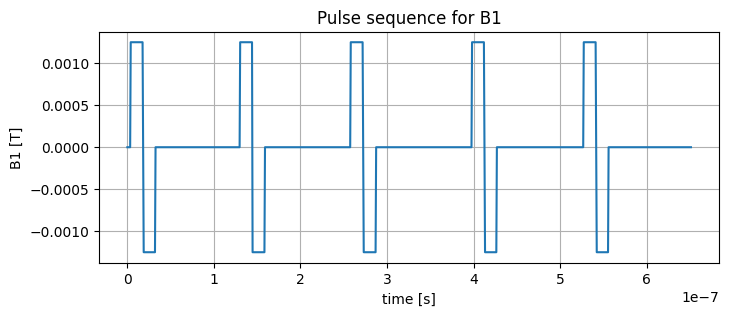

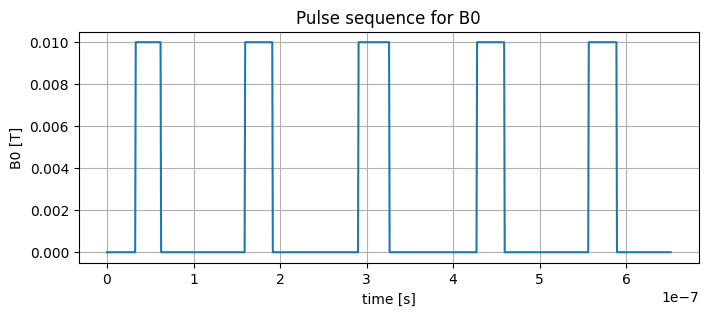

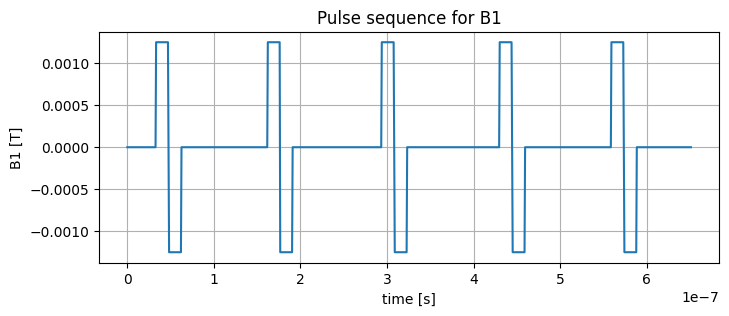

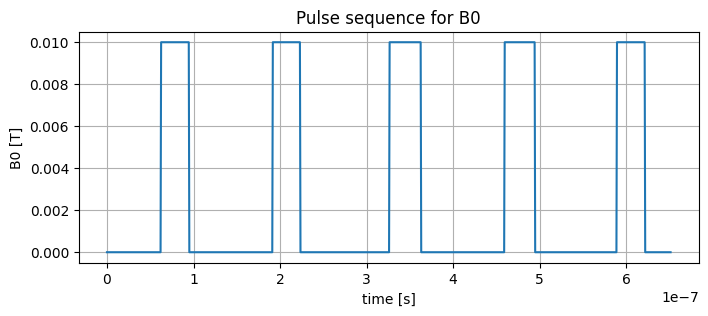

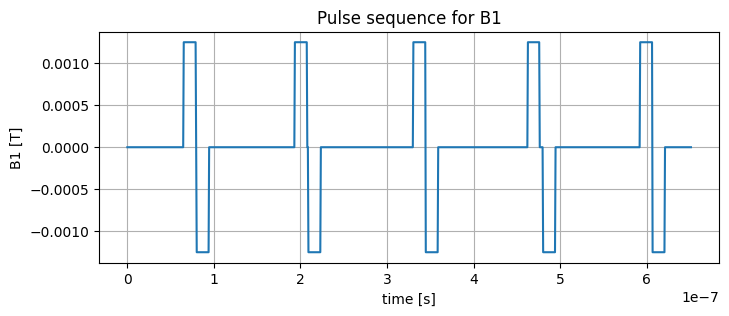

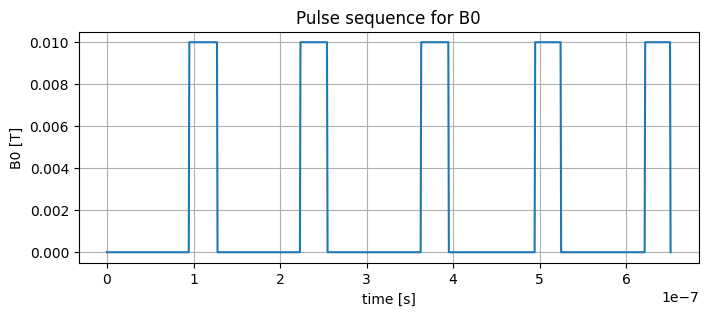

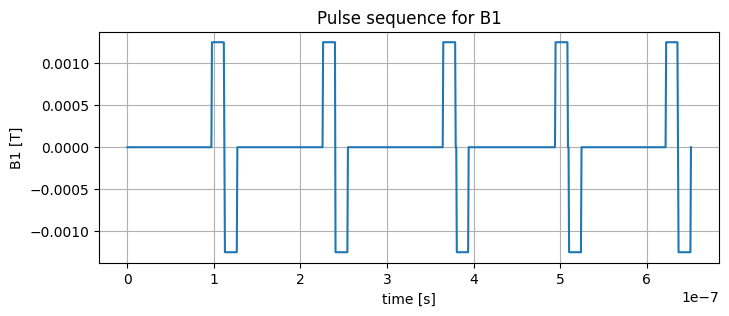

In [ ]:
plot_pulses_v2(dru_circuit)

### Pulsos 4 qubits - con entrelazamiento

In [ ]:
X, y =  make_IRIS_v2(3,3)

model = Modelo_DRU(qcircuit_4_qubit_mixed, Trace_Distance_v3,
                        epochs = 2, n_clases = 3, n_qubits = 4,
                        features = 3, num_layers = 5, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, entanglement = True)

paramters_4q_w_ent, bias_4q_w_ent = model.fit(X, y)

Epoch: 100%|██████████| 2/2 [00:36<00:00, 18.28s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,
                                     N_qubits = 4,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0)),
                                     J = 12e6)

state_dru = dru_circuit.qcircuit_DRU_4_Qubit(paramters_4q_w_ent,
                                             model.X_val[1],
                                             bias=bias_4q_w_ent,
                                             entanglement = True)

Contador general 0
Entro par en 0
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
Contador general 1
Entro impar en 1
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
[0, 3]
time_swap = 2.617993877991494e-07
time_swap = 2.617993877991494e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_swap = 2.617993877991494e-07
time_swap = 2.617993877991494e-07
Contador general 2
Entro par en 2
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
Contador general 3
Entro impar en 3
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
[0, 3]
time_swap = 2.617993877991494e-07
time_swap = 2.617993877991494e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_swap = 2.6179

#### Version actual

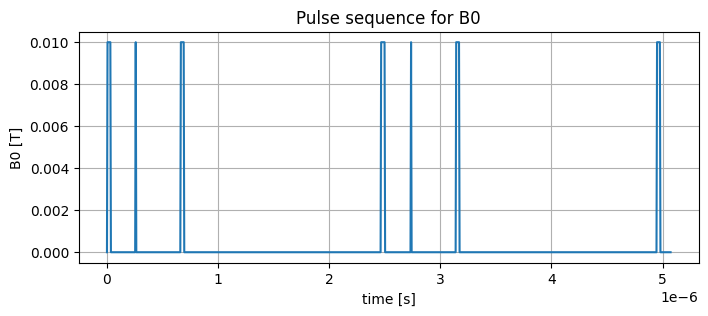

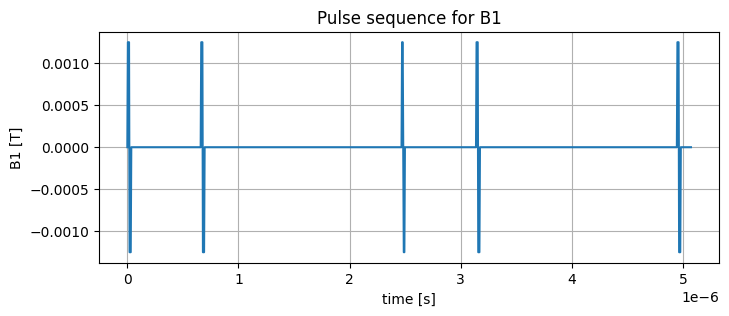

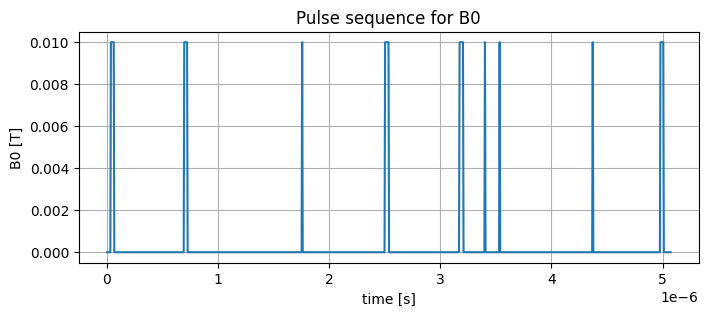

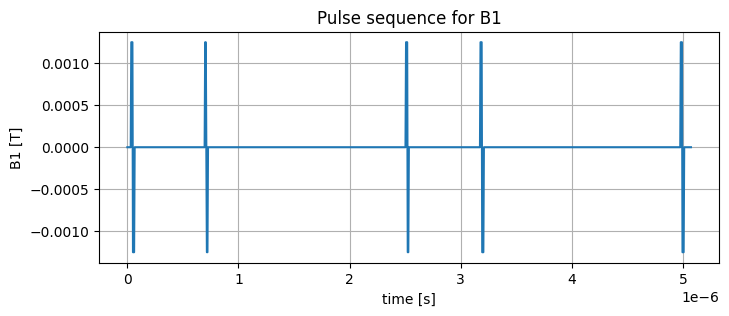

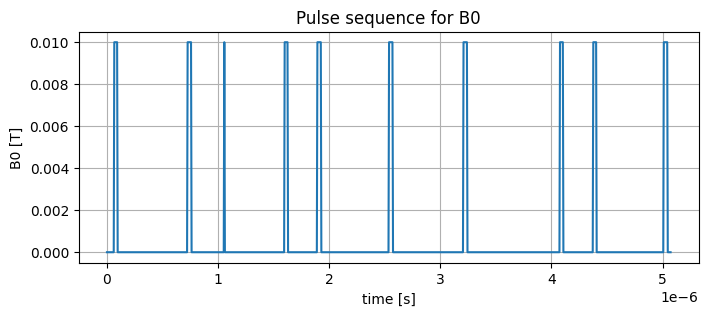

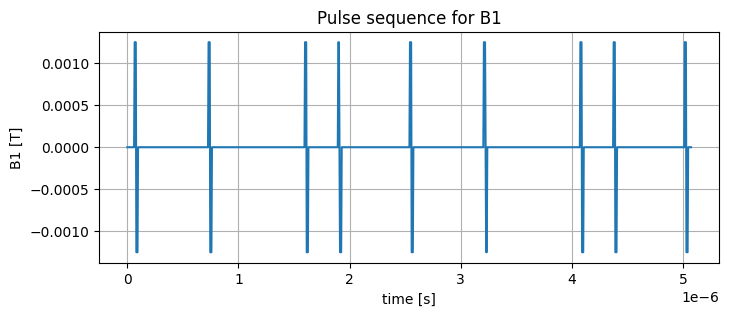

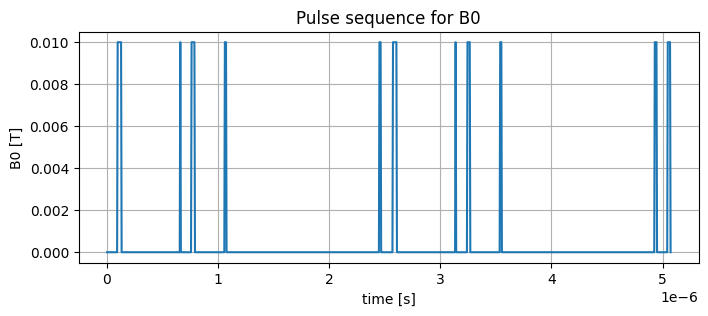

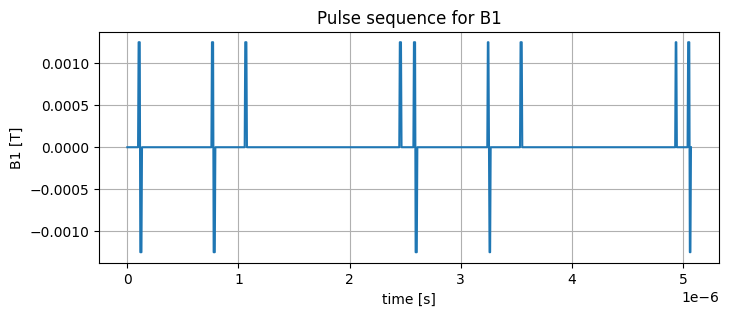

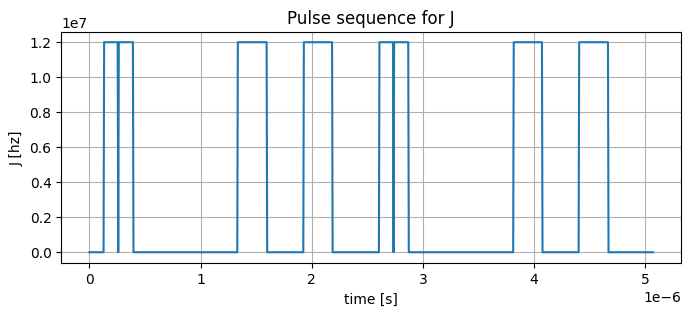

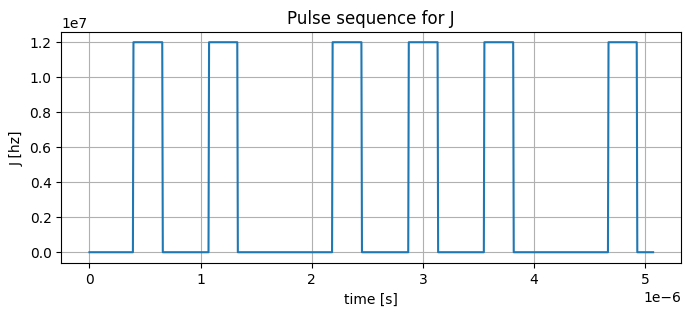

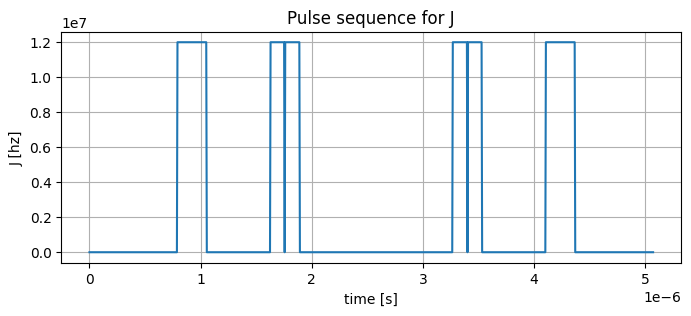

In [ ]:
plot_pulses_v2(dru_circuit)

##  Fidelidad


In [ ]:
# entanglement
import statistics
def plot_fidelity(model, path_before, entanglement = False):
  before, dict_samples_before_1_qubit = w_r_json('r', path_before)
  # params before
  np.random.seed(42)
  params = np.random.uniform(size=(model.n_qubits*model.num_layers, 3), requires_grad=True)
  bias = np.random.uniform(size=(model.n_qubits*model.num_layers, 3), requires_grad=True)
  # get states
  list_dict_states_spin_dru = []
  for xi in model.X_train:
    #print(xi)
    if model.n_qubits == 1:
      dru_circuit_1_q = CompositeGateProcessor(n_points_pulse_Ri=100, N_qubits = 1)
      state_dru = dru_circuit_1_q.qcircuit_DRU_1_Qubit(params, xi, bias=bias, entanglement = entanglement)
      list_dict_states_spin_dru.append(dru_circuit_1_q.dict_states)
    elif model.n_qubits == 2:
      dru_circuit_2_q = CompositeGateProcessor(n_points_pulse_Ri=100, N_qubits = 2,
                                               ket_dru_0 = tensor(basis(2, 0),basis(2, 0)),
                                               J = 12e6)
      state_dru = dru_circuit_2_q.qcircuit_DRU_2_Qubit(params, xi, bias=bias,  entanglement = entanglement)
      list_dict_states_spin_dru.append(dru_circuit_2_q.dict_states)
    elif model.n_qubits == 4:
      dru_circuit_4_q = CompositeGateProcessor(n_points_pulse_Ri=100, N_qubits = 4,
                                               ket_dru_0 = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0)),
                                                J = 12e6)
      state_dru = dru_circuit_4_q.qcircuit_DRU_4_Qubit(params, xi, bias=bias,
                                               entanglement = entanglement)
      list_dict_states_spin_dru.append(dru_circuit_4_q.dict_states)
  # Obtener fidelidad por estado:
  N_states_bl = len(dict_samples_before_1_qubit)
  N_states_spin = len(list_dict_states_spin_dru)
  print(f"N sates base line {N_states_bl} \n N sates spin {N_states_spin}")
  dict_states_fidelities = []
  for i in range(N_states_bl):
    dict_bl = dict_samples_before_1_qubit[i]
    dict_spin = list_dict_states_spin_dru[i]
    Fidelities_by_state = {}
    try:
      for key in dict_bl:
        state_spin = dict_spin[key]
        state_bl_i = dict_bl[key].numpy()
        state_bl_i  = Qobj(state_bl_i)
        state_spin  = Qobj(state_spin)
        F = fidelity_qutip(state_spin, state_bl_i)
        Fidelities_by_state[key] = F
    except:
      pass
    dict_states_fidelities.append(Fidelities_by_state)
  # Grafica
  # Organizar los datos para facilitar el cálculo del promedio

  #ket_labels = [f'ket_{model.n_qubits}_qubits_{i}' for i in range(len(dict_states_fidelities[0]))]
  ket_labels = list(dict_states_fidelities[0].keys())
  #if entanglement == True and model.n_qubits == 2:
  #  ket_labels_e = []
  #  for i in range(len(dict_states_fidelities[0])):
  #    ket_labels_e.append()

  promedios = {ket: [] for ket in ket_labels}

  for diccionario in dict_states_fidelities:
      for ket, valor in diccionario.items():
          promedios[ket].append(valor)

  # Calcular el promedio para cada 'ket_1_qubit_i'
  promedios_mean = {ket: sum(valores) / len(valores) for ket, valores in promedios.items()}
  promedios_desviacion = {key: statistics.stdev(values) for key, values in promedios.items()}
  # Crear el diagrama de barras
  plt.figure(figsize=(8, 4))
  plt.grid()
  plt.bar(promedios_mean.keys(), promedios_mean.values(), yerr=list(promedios_desviacion.values()), capsize=5, color='blue', alpha=0.7)
  plt.xlabel('Qubits')
  plt.ylabel('Promedio')
  plt.title(f'Promedio de ket_{model.n_qubits}_qubits_i a través de diccionarios')
  plt.xticks(rotation=45)
  plt.ylim(min(promedios_mean.values()) - 0.00000001, max(promedios_mean.values()) + 0.00000001)

  plt.show()


### Fidelidad 1 qubit

In [ ]:
X, y =  make_IRIS_v2(3,3)

model = Modelo_DRU(qcircuit_1_qubit_mixed, Trace_Distance,
                        epochs = 2, n_clases = 3, n_qubits = 1,
                        features = 3, num_layers = 3, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = True)

paramters_1q, bias_1q = model.fit(X, y)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000,
                                     N_qubits = 1,
                                     tf_noise = False,
                                     noise_std = 0.0000)

state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q)

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]


[-3.21593942  0.13346807  0.29239675]


N sates base line 120 
 N sates spin 120


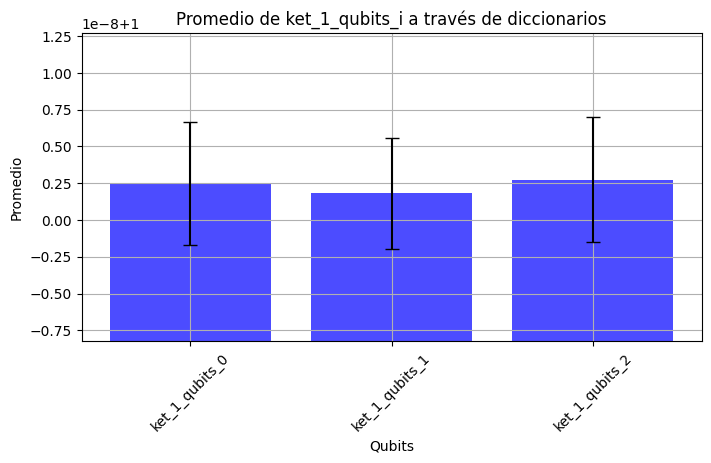

In [ ]:
np.random.seed(42)
path_before = "/content/test_states_before_states.json"
plot_fidelity(model, path_before, entanglement = False)

### Fidelidad 2 qubits sin entrelazamiento

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 2/2 [00:17<00:00,  8.76s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[-3.21593942  0.13346807  0.29239675]
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = (6, 3)
N_layers = 3
params_shape = (6, 3)
params_shape = 

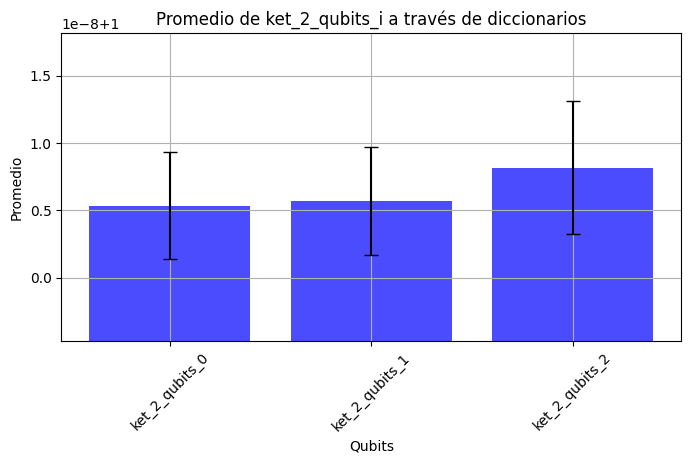

In [ ]:
X, y =  make_IRIS_v2(3,3)

tf_entanglement = False

model = Modelo_DRU(qcircuit_2_qubit_mixed, Trace_Distance_v3,
                        epochs = 2, n_clases = 3, n_qubits = 2,
                        features = 3, num_layers = 3, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = True,
                        entanglement = tf_entanglement )

paramters_2q, bias_2q = model.fit(X, y)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000,
                                     N_qubits = 2,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0)))

state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_2q,
                                             model.X_val[1],
                                             bias=bias_2q,
                                             entanglement = tf_entanglement)

plot_fidelity(model, path_before, entanglement = tf_entanglement)

### Fidelidad 2 qutbis con entrelazamiento

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 2/2 [00:08<00:00,  4.38s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[-3.21593942  0.13346807  0.29239675]
N_layers = 2
params_shape = (4, 3)
params_shape = (4, 3)
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
N_layers = 2
params_shape = (4, 3)
params_shape = (4, 3)
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
N_layers = 2
params_shape = (4, 3)
params_shape = (4, 3)
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
N_layers = 2
params_shape = (4, 3)
params_shape = (4, 3)
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
N_layers = 2
params_shape = (4, 3)
params_shape = (4, 3)
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap

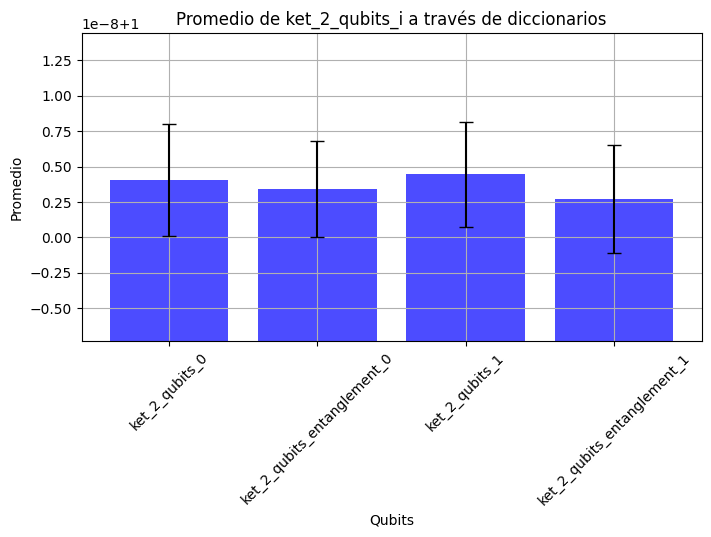

In [ ]:
X, y =  make_IRIS_v2(3,3)

tf_entanglement = True

model = Modelo_DRU(qcircuit_2_qubit_mixed, Trace_Distance_v3,
                        epochs = 2, n_clases = 3, n_qubits = 2,
                        features = 3, num_layers = 2, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = True,
                        entanglement = tf_entanglement )

paramters_2q, bias_2q = model.fit(X, y)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000,
                                     N_qubits = 2,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0)),
                                     J = 12e6)

state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_2q,
                                             model.X_val[1],
                                             bias=bias_2q,
                                             entanglement = tf_entanglement)

plot_fidelity(model, path_before, entanglement = tf_entanglement)

### Fidelidad 4 qubits sin entrelazamiento

In [ ]:
X, y =  make_IRIS_v2(3,3)

model = Modelo_DRU(qcircuit_4_qubit_mixed, Trace_Distance_v3,
                        epochs = 2, n_clases = 3, n_qubits = 4,
                        features = 3, num_layers = 3, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = True)

paramters_2q, bias_2q = model.fit(X, y)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000,
                                     N_qubits = 4,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0)))

state_dru = dru_circuit.qcircuit_DRU_4_Qubit(paramters_2q,
                                             model.X_val[1],
                                             bias=bias_2q,
                                             entanglement = False)

Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador general 1
Contador general 2
Contador general 0
Contador gen

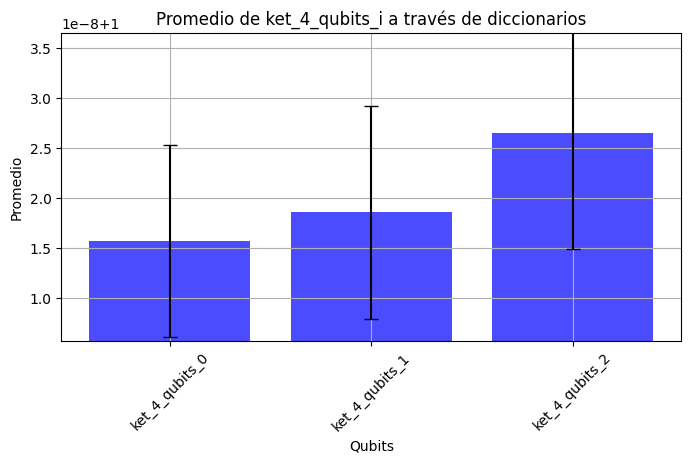

In [ ]:
plot_fidelity(model, path_before)

### Fidelidad 4 qubits con entrelazamiento

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 2/2 [00:23<00:00, 11.93s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[-3.21593942  0.13346807  0.29239675]
Contador general 0
Entro par en 0
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
Contador general 1
Entro impar en 1
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
[0, 3]
time_swap = 2.617993877991494e-07
time_swap = 2.617993877991494e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_swap = 2.617993877991494e-07
time_swap = 2.617993877991494e-07
Contador general 2
Contador general 0
Entro par en 0
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
Contador general 1
Entro impar en 1
time_sqrt_swap = 1.308996938995747e-07
time_sqrt_swap = 1.308996938995747e-07
[0, 3]
time_swap = 2.617993877991494e-07
time_swap = 2.617993877991494e-07
time_sqrt_swap = 1.308996938995747e-07


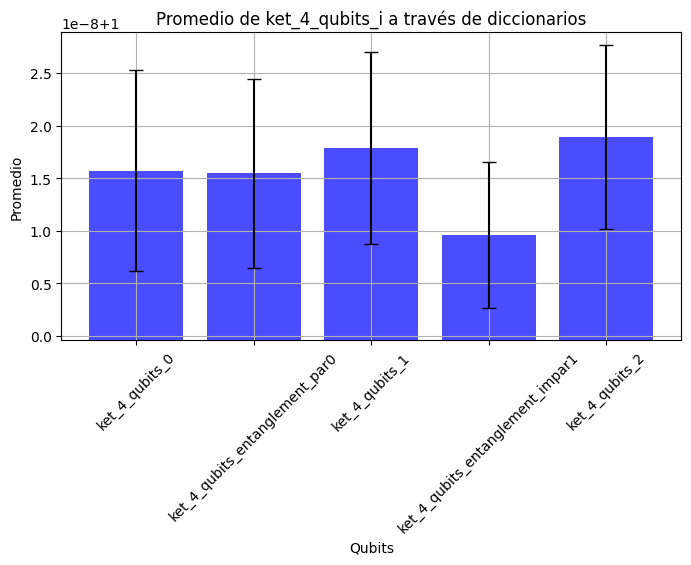

In [ ]:
X, y =  make_IRIS_v2(3,3)

tf_entanglement = True

model = Modelo_DRU(qcircuit_4_qubit_mixed, Trace_Distance_v3,
                        epochs = 2, n_clases = 3, n_qubits = 4,
                        features = 3, num_layers = 3, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = True,
                        entanglement = tf_entanglement)

paramters_2q, bias_2q = model.fit(X, y)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,
                                     N_qubits = 4,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0)),
                                     J = 12e6)

state_dru = dru_circuit.qcircuit_DRU_4_Qubit(paramters_2q,
                                             model.X_val[1],
                                             bias=bias_2q,
                                             entanglement = tf_entanglement)

plot_fidelity(model, path_before, entanglement = tf_entanglement)

# Introduccion ruido cuantico

## Prueba III

In [ ]:
def pulse_x(t, args):
  t_init = args["t_init"]
  t_final = args["t_final"]
  y = np.heaviside((t-t_init), 0.0) * np.heaviside(-(t - t_final), 0.0)
  return y


def pulse_z(t, args):
  t_init = args["t_init"]
  t_final = args["t_final"]
  y = np.heaviside((t-t_init), 0.0) * np.heaviside(-(t - t_final), 0.0)
  return y

In [ ]:
from qutip import create, destroy

In [ ]:
class X_pulse:

  def __init__(self, B0, gir, T1, T2):
    self.B0 = B0
    self.gir = gir
    self.h = 1
    self.noise_std = 0
    self.tf_noise = False
    self.T1 = T1
    self.T2 = T2
    self.n_points_pulse_Ri = 1000
  def Rx(self, alpha, ket_0, q_obj = 0, tf_expect = True, tf_quantum_noise = True):
    # Estados iniciales y qubit objetivo:
    self.q_obj = q_obj
    self.ket_0 = ket_0
    # parametros de compuerta:
    self.ω_x = self.gir * self.B0
    self.ω_z = self.gir * self.B0
    self.delt_t = (2*np.pi*1)/self.ω_x
    self.B1 = (alpha * 2)/(self.gir * self.delt_t)
    self.O_x = self.gir*(self.B1/2)
    # solucion:
    out = self.Hamiltonian_solve(tf_expect, tf_quantum_noise)
    return out


  def Hamiltonian_solve(self, tf_expect = True, tf_quantum_noise = True):
    # Hamiltonian H0
    h0_constant = - (self.h/2) * (self.ω_x) # + (self.h/2) * (self.ω_z)
    h1_constant =   (self.h/2) * (self.ω_z)
    h2_constant =   (self.h/2) * (self.O_x)
    apply_qbit_z = [sigmaz()]
    apply_qbit_x = [sigmax()]
    H0 = h0_constant * tensor(*apply_qbit_z)
    H1 = h1_constant * tensor(*apply_qbit_z)
    H2 = h2_constant * tensor(*apply_qbit_x)

    # Correccion de desviacion estandar:
    if self.B1 != 0:
      dv = self.noise_std/abs(self.B1)
    else:
      dv = 0
    self.args = { "t_init": 0, "t_final": self.delt_t, "std_noise": dv}
    self.tlist  = np.linspace(0, 6e-5, self.n_points_pulse_Ri)
    # Hamiltonian
    if self.tf_noise == False:
      H = [H0, [H1, pulse_z], [H2, pulse_x]]
    else:
      noise_x = pulse_x_with_noise(self.tlist, self.args)
      S_x = Cubic_Spline(self.tlist[0], self.tlist[-1], noise_x)
      H = [H0, [H1, pulse_z], [H2, S_x]]
      # Guardar pulso
    if tf_expect:
      e_ops = [sigmax(), sigmay(), sigmaz()]
    else:
      e_ops = []

    if tf_quantum_noise:
      a = destroy(2)
      print("Entro aca")
      T2_star = 1/((1/self.T2) - (1/(2*self.T1)))
      print(T2_star)
      c1 = a/(np.sqrt(self.T1))
      c2 = a.dag()*a*np.sqrt(2/T2_star)
      c_ops = [c1, c2]
    else:
      c_ops = []

    self.output_rwa = mesolve(H, self.ket_0, self.tlist, c_ops, e_ops, self.args)

    return self.output_rwa

In [ ]:
85e-6

8.5e-05

Entro aca
2.326757713707638e-05


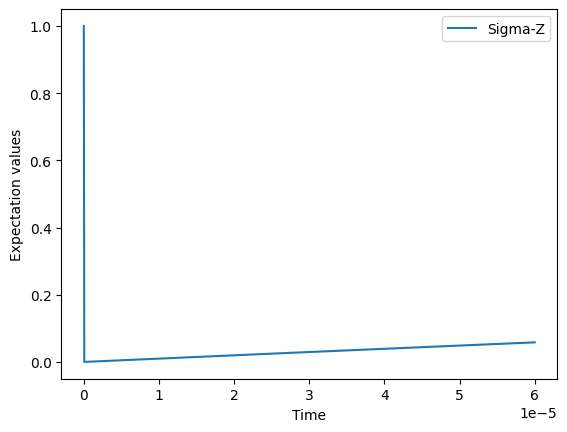

In [ ]:
gir = 1.760e11
B0 = 10e-3
psi0 = basis(2, 0)
m = X_pulse(B0, gir, 1e-3, 23e-6)
s = m.Rx(np.pi/2, psi0)


fig, ax = plt.subplots()

ax.plot(m.tlist, s.expect[2])

ax.set_xlabel('Time')

ax.set_ylabel('Expectation values')

ax.legend(("Sigma-Z", "Sigma-Y"))

plt.show()

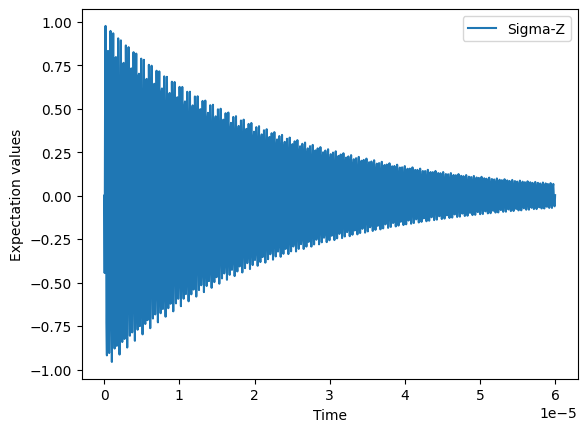

In [ ]:
fig, ax = plt.subplots()

ax.plot(m.tlist, s.expect[1])

ax.set_xlabel('Time')

ax.set_ylabel('Expectation values')

ax.legend(("Sigma-Z", "Sigma-Y"))

plt.show()

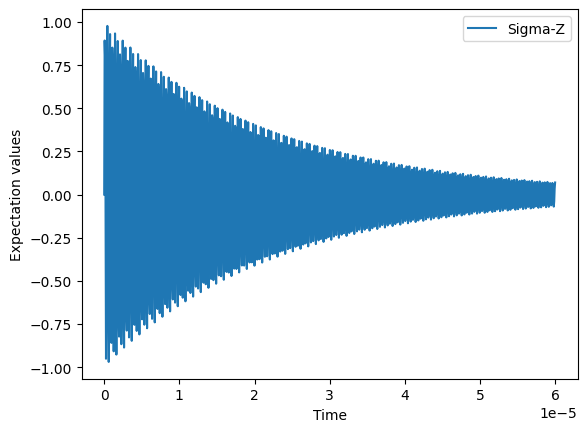

In [ ]:
fig, ax = plt.subplots()

ax.plot(m.tlist, s.expect[0])

ax.set_xlabel('Time')

ax.set_ylabel('Expectation values')

ax.legend(("Sigma-Z", "Sigma-Y"))

plt.show()

In [ ]:
s.expect[0]

array([ 0.        , -0.98372402, -0.34882517, ..., -0.00224631,
        0.00356235,  0.00350759])

Parámetros optimizados con fase: [1.00008332e+00 1.84575099e+07 4.43210044e+04]


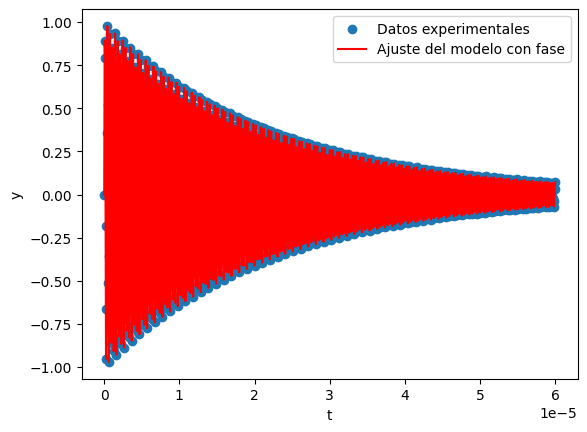

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Función a ajustar con fase
def modelo_con_fase(t, a, b, c):
    return (a * np.sin(b * t)) * np.exp(-c * t)

# Datos experimentales
t_experimental = m.tlist
y_experimental = s.expect[0]

# Realizar el ajuste de curva
parametros_iniciales_con_fase = [2.0, 2e7, 2e5]  # Valores iniciales para a, b, c y fase
parametros_optimizados_con_fase, covarianza_con_fase = curve_fit(
    modelo_con_fase, t_experimental, y_experimental, p0=parametros_iniciales_con_fase
)

# Imprimir los parámetros optimizados
print("Parámetros optimizados con fase:", parametros_optimizados_con_fase)

# Graficar los datos experimentales y la curva ajustada con fase
t_prediccion = t_experimental.copy()  # Valores de t para la predicción
y_prediccion_con_fase = modelo_con_fase(t_prediccion, *parametros_optimizados_con_fase)

plt.scatter(t_experimental, y_experimental, label='Datos experimentales')
plt.plot(t_prediccion, y_prediccion_con_fase, label='Ajuste del modelo con fase', color='red')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()


In [ ]:
1/4.43210034e+04

2.256266607899044e-05